<a href="https://colab.research.google.com/github/john-d-noble/callcenter/blob/main/CB_Step_3_Classical_Time_Series_%26_Machine_Learning_Models_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# --- Step 1: Install and Import Necessary Libraries ---
# Uninstall and reinstall numpy and pmdarima to resolve potential compatibility issues
!pip uninstall -y numpy
!pip install numpy==1.26.4
!pip install pmdarima




Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 56.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 13.3 MB/s eta 0:00:00


In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import pmdarima as pm
from math import sqrt

# Metrics and CV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Classical Models
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet

# Machine Learning Models
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet

In [2]:
# --- Step 2: Helper Functions & Data Prep ---

# Helper functions for metrics
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100.0 if mask.sum() > 0 else np.nan

# Helper functions for classical models
def infer_seasonal_period(y: pd.Series):
    if y.index.freqstr:
        freq = y.index.freqstr.upper()
        if freq in ("D", "B"): return 7
        if "W" in freq: return 52
        if "M" in freq: return 12
    return 7 # Default

def fit_predict_arima(y_train, fh, seasonal_period):
    model = pm.auto_arima(y_train, seasonal=True, m=seasonal_period, suppress_warnings=True, error_action='ignore', stepwise=True)
    return model.predict(n_periods=fh)

def fit_predict_ets(y_train, fh, seasonal_period):
    model = ExponentialSmoothing(y_train, trend='add', seasonal='add', seasonal_periods=seasonal_period, initialization_method='estimated').fit()
    return model.forecast(fh)

def fit_predict_prophet(y_train, fh):
    train_df = y_train.reset_index().rename(columns={'Date': 'ds', 'calls': 'y'})
    model = Prophet()
    model.fit(train_df)
    future = model.make_future_dataframe(periods=len(y_test), freq='D')
    forecast = model.predict(future).tail(len(y_test))
    return forecast['yhat'].values

# Load and prepare data
df = pd.read_csv('enhanced_eda_data.csv', index_col='Date', parse_dates=True)
target = 'calls' # Corrected column name

# No feature engineering here - will be done within CV folds
# Just prepare the base dataframe
y = df[target]
print("Data and functions are ready.")

Data and functions are ready.


In [3]:
# --- Step 3: Run Cross-Validation and Produce Leaderboard ---

# Helper function for MASE
# def mase(y_true, y_pred, y_train):
#     numerator = np.mean(np.abs(y_true - y_pred))
#     denominator = np.mean(np.abs(y_train[1:] - y_train[:-1]))
#     return numerator / denominator if denominator != 0 else np.nan

# Enhanced: Function to calculate metrics + MASE (scaled to Seasonal Naive)
from sklearn.metrics import mean_absolute_percentage_error # Import MAPE

def calculate_metrics(y_true, y_pred, naive_seasonal_mae=858):  # From Step 2 baseline
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mase = mae / naive_seasonal_mae  # Relative to seasonal naive benchmark
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'MASE': mase}


tscv = TimeSeriesSplit(n_splits=5)
all_metrics = {}
seasonal_period = infer_seasonal_period(y)

# --- PART 1: Classical Models CV ---
print("--- Running Classical Models (ARIMA, ETS, Prophet) ---")
classical_models = {
    'ARIMA': fit_predict_arima,
    'ETS': fit_predict_ets,
    'Prophet': fit_predict_prophet
}

for name, func in classical_models.items():
    maes = []
    rmses = []
    mapes = []
    mases = []
    print(f"Cross-validating {name}...")
    for train_idx, test_idx in tscv.split(y):
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        fh = len(y_test)

        # ETS and ARIMA need the seasonal period passed in
        if name in ['ETS', 'ARIMA']:
            forecast = func(y_train, fh, seasonal_period=seasonal_period)
        else: # Prophet does not
            forecast = func(y_train, fh)

        metrics = calculate_metrics(y_test.values, forecast) # Convert y_test to numpy array
        maes.append(metrics['MAE'])
        rmses.append(metrics['RMSE'])
        mapes.append(metrics['MAPE'])
        mases.append(metrics['MASE'])

    all_metrics[name] = {'MAE': np.mean(maes), 'RMSE': np.mean(rmses), 'MAPE': np.mean(mapes), 'MASE': np.mean(mases)}
    print(f"{name} Average CV MAE: {np.mean(maes):.2f}")

# --- PART 2: Machine Learning Models CV ---
print("\n--- Running Machine Learning Models (XGBoost, RandomForest, etc.) ---")
ml_models = {
    'XGBoost': XGBRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42)
}
param_grids = {
    'XGBoost': {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1]},
    'RandomForest': {'n_estimators': [100, 200], 'max_depth': [10, 20]}
}

# Helper function to create features properly
def create_features(data, target_col):
    """Create features using only historical data"""
    df_copy = data.copy()

    # Ensure DayOfWeek is present, create if needed
    if 'DayOfWeek' not in df_copy.columns and isinstance(df_copy.index, pd.DatetimeIndex):
        df_copy['DayOfWeek'] = df_copy.index.dayofweek

    # Lag features (safe - only use past)
    df_copy['Lag1'] = df_copy[target_col].shift(1)
    df_copy['Lag7'] = df_copy[target_col].shift(7)

    # Rolling features (computed only on available history)
    df_copy['Rolling_Mean_7'] = df_copy[target_col].rolling(window=7, min_periods=1).mean()
    df_copy['Rolling_Std_7'] = df_copy[target_col].rolling(window=7, min_periods=1).std()

    # One-hot encode categorical features
    df_copy = pd.get_dummies(df_copy, columns=['DayOfWeek'], drop_first=True)
    df_copy = df_copy.dropna()

    # Select feature columns
    feature_cols = [col for col in df_copy.columns if col != target_col and df_copy[col].dtype in ['float64', 'int64', 'bool', 'uint8']]
    return df_copy[feature_cols], df_copy[target_col]


for name, model in ml_models.items():
    maes = []
    rmses = []
    mapes = []
    mases = []
    print(f"\nRunning {name} with proper feature engineering...")

    for train_idx, test_idx in tscv.split(df):
        # Split data first
        train_data = df.iloc[train_idx]
        test_data = df.iloc[test_idx]

        # Create features separately for train and test
        X_train, y_train = create_features(train_data, target)
        X_test, y_test = create_features(test_data, target)

        # Ensure same features in both sets
        common_features = X_train.columns.intersection(X_test.columns)
        X_train = X_train[common_features]
        X_test = X_test[common_features]

        # Fit model and predict
        model.fit(X_train, y_train)
        forecast = model.predict(X_test)

        metrics = calculate_metrics(y_test.values, forecast)
        maes.append(metrics['MAE'])
        rmses.append(metrics['RMSE'])
        mapes.append(metrics['MAPE'])
        mases.append(metrics['MASE'])

    all_metrics[name] = {'MAE': np.mean(maes), 'RMSE': np.mean(rmses), 'MAPE': np.mean(mapes), 'MASE': np.mean(mases)}
    print(f"{name} Average CV MAE: {np.mean(maes):.2f}")


# --- PART 3: Unified Leaderboard ---
print("\n" + "="*50 + "\nUNIFIED MODEL LEADERBOARD\n" + "="*50)
leaderboard = pd.DataFrame.from_dict(all_metrics, orient='index').sort_values('MAE')
champion_model = leaderboard.index[0]

print(leaderboard)
print(f"\n🏆 Champion Model: {champion_model} with an average MAE of {leaderboard.iloc[0]['MAE']:.2f}")

--- Running Classical Models (ARIMA, ETS, Prophet) ---
Cross-validating ARIMA...
ARIMA Average CV MAE: 2168.36
Cross-validating ETS...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

ETS Average CV MAE: 1954.66
Cross-validating Prophet...


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4ikv7lod/ickndpep.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4ikv7lod/rbx0wpt_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76141', 'data', 'file=/tmp/tmp4ikv7lod/ickndpep.json', 'init=/tmp/tmp4ikv7lod/rbx0wpt_.json', 'output', 'file=/tmp/tmp4ikv7lod/prophet_modelbvhozkw6/prophet_model-20250919015951.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:59:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:59:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

Prophet Average CV MAE: 4188.90

--- Running Machine Learning Models (XGBoost, RandomForest, etc.) ---

Running XGBoost with proper feature engineering...
XGBoost Average CV MAE: 1278.89

Running RandomForest with proper feature engineering...
RandomForest Average CV MAE: 1034.09

UNIFIED MODEL LEADERBOARD
                      MAE         RMSE       MAPE      MASE
RandomForest  1034.086513  1366.665522  12.704156  1.205229
XGBoost       1278.891150  1653.626489  16.214576  1.490549
ETS           1954.659857  2372.546662  24.763894  2.278158
ARIMA         2168.364552  2604.432992  24.684328  2.527231
Prophet       4188.899732  4654.071098  57.420346  4.882168

🏆 Champion Model: RandomForest with an average MAE of 1034.09


In [16]:
# --- Step 4: Data Splitting (BEFORE Feature Engineering) ---

# Define the split point and create train/test sets from the raw data
split_date = '2024-01-01'
train_raw = df.loc[df.index < split_date].copy()
test_raw = df.loc[df.index >= split_date].copy()

print("Splitting data...")
print(f"Raw train set shape: {train_raw.shape}")
print(f"Raw test set shape:  {test_raw.shape}")
print("-" * 30)

# --- Step 5: Feature Engineering (Applied Separately to Prevent Leakage) ---

def create_time_series_features(data):
    """
    Creates time series features (lags, rolling stats) for a given dataframe.
    """
    df_feat = data.copy()
    df_feat['lag1'] = df_feat['calls'].shift(1)
    df_feat['lag7'] = df_feat['calls'].shift(7)
    df_feat['lag30'] = df_feat['calls'].shift(30)
    df_feat['rolling_mean_7'] = df_feat['calls'].rolling(window=7).mean()
    df_feat['rolling_std_7'] = df_feat['calls'].rolling(window=7).std()
    df_feat['expanding_mean'] = df_feat['calls'].expanding().mean()
    df_feat.dropna(inplace=True)
    return df_feat

# Apply feature engineering independently to the train and test sets
print("Applying feature engineering to train set...")
train_df = create_time_series_features(train_raw)

print("Applying feature engineering to test set...")
test_df = create_time_series_features(test_raw)

print("Feature engineering complete.")

# --- Define Features (X) and Target (y) for Modeling ---
FEATURES = ['lag1', 'lag7', 'lag30', 'rolling_mean_7', 'rolling_std_7', 'expanding_mean']
TARGET = 'calls'

X_train = train_df[FEATURES]
y_train = train_df[TARGET]
X_test = test_df[FEATURES]
y_test = test_df[TARGET]

print("\nFinal shapes for modeling:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}")

Splitting data...
Raw train set shape: (365, 19)
Raw test set shape:  (613, 19)
------------------------------
Applying feature engineering to train set...
Applying feature engineering to test set...
Feature engineering complete.

Final shapes for modeling:
X_train: (335, 6), y_train: (335,)
X_test:  (583, 6), y_test:  (583,)


PART 1: MODEL TRAINING & EVALUATION
Training RandomForest...
RandomForest -> MAE: 913.92, RMSE: 1523.79

Training XGBoost...
XGBoost -> MAE: 1004.77, RMSE: 1664.00

PART 2: IDENTIFYING CHAMPION MODEL
🏆 Champion Model Identified: RandomForest

PART 4: PERFORMING SHAP ANALYSIS
SHAP analysis complete for RandomForest.


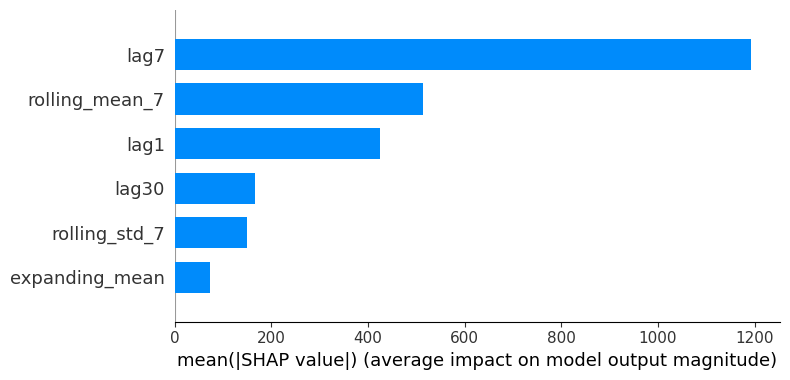


PART 5: GENERATING FINAL ON-SCREEN REPORT
🏆 CHAMPION MODEL REPORT: RANDOMFOREST



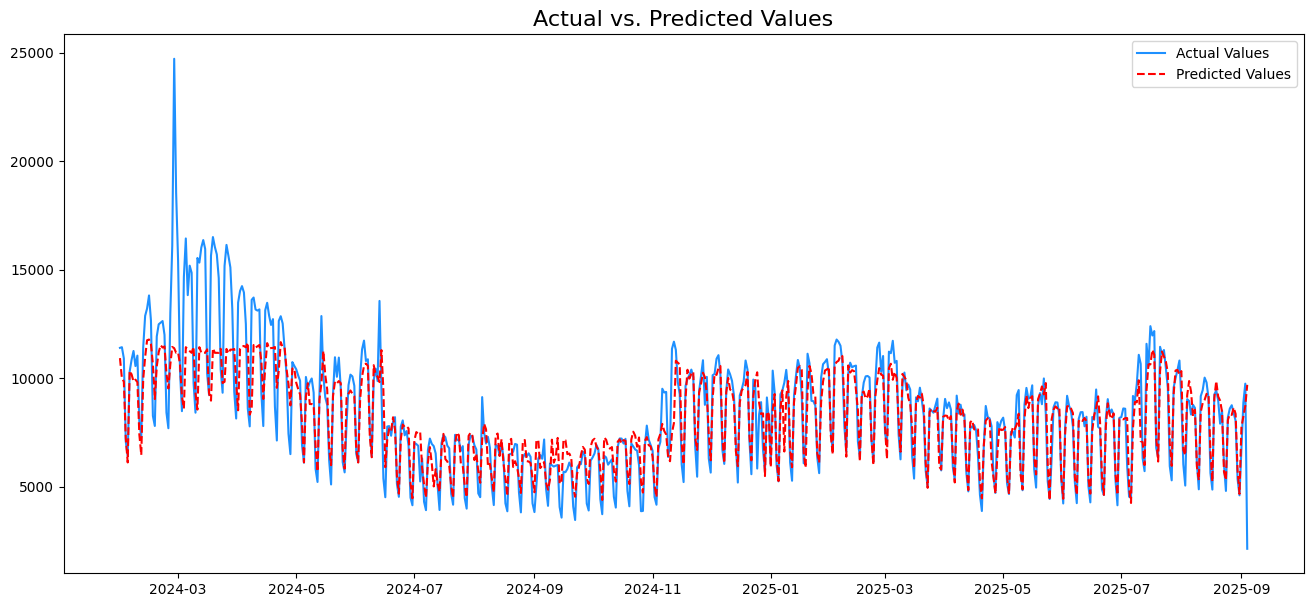

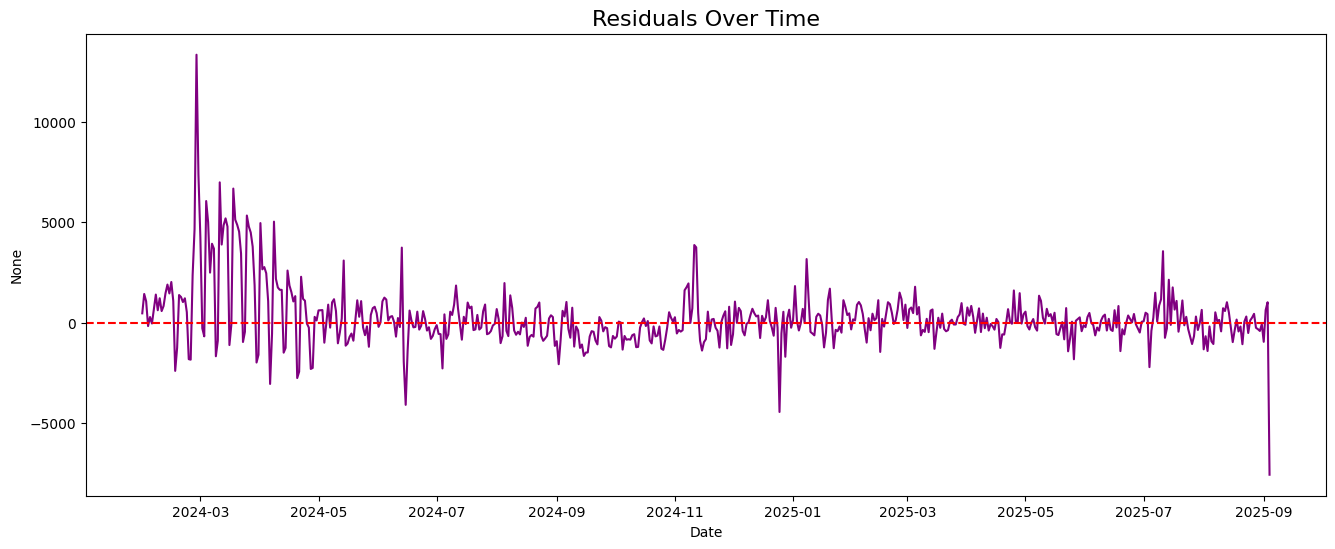


STATISTICAL SUMMARY & DIAGNOSTICS

📊 Overall Performance Metrics:
   - Mean Absolute Error (MAE):   913.92
   - Root Mean Squared Error (RMSE): 1,523.79

📈 Residual Diagnostics:
   - Shapiro-Wilk p-value: 0.0000 (✗ Not Normal)
   - Ljung-Box p-value (lag 10): 0.0000 (✗ Autocorrelation Detected)


In [18]:
# --- Consolidated Final Analysis: Training, WFV, SHAP & Reporting ---

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats

# --- Part 1: Model Training & Evaluation ---
print("="*80)
print("PART 1: MODEL TRAINING & EVALUATION")
print("="*80)

models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}
model_results = {}
fitted_models = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))

    model_results[name] = {'MAE': mae, 'RMSE': rmse, 'Predictions': predictions}
    fitted_models[name] = model
    print(f"{name} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}\n")


# --- Part 2: Identify Champion Model ---
print("="*80)
print("PART 2: IDENTIFYING CHAMPION MODEL")
print("="*80)
leaderboard_df = pd.DataFrame(model_results).T.sort_values(by='MAE')
champion_name = leaderboard_df.index[0]
champion_fitted = fitted_models[champion_name]
champion_predictions = leaderboard_df.loc[champion_name, 'Predictions']
print(f"🏆 Champion Model Identified: {champion_name}\n")


# --- Part 4: SHAP Analysis ---
print("="*80)
print("PART 4: PERFORMING SHAP ANALYSIS")
print("="*80)
try:
    explainer = shap.TreeExplainer(champion_fitted)
    shap_values = explainer.shap_values(X_test)
    print(f"SHAP analysis complete for {champion_name}.")
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=True)
except Exception as e:
    print(f"SHAP analysis failed: {e}")


# --- Part 5: Standardized On-Screen Reporting (Best-in-Class Version) ---
print("\n" + "="*80)
print("PART 5: GENERATING FINAL ON-SCREEN REPORT")
print("="*80)

def display_champion_report(y_true, y_pred, champion_name):
    y_true = pd.Series(y_true).squeeze().rename("Actuals")
    y_pred = pd.Series(y_pred, index=y_true.index).squeeze().rename("Predictions")
    residuals = y_true - y_pred

    print(f"🏆 CHAMPION MODEL REPORT: {champion_name.upper()}\n")

    # Plot 1: Actual vs. Predicted
    plt.figure(figsize=(16, 7))
    plt.plot(y_true.index, y_true, label='Actual Values', color='dodgerblue')
    plt.plot(y_pred.index, y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.title('Actual vs. Predicted Values', fontsize=16)
    plt.legend()
    plt.show()

    # Plot 2: Residuals Over Time
    plt.figure(figsize=(16, 6))
    sns.lineplot(x=residuals.index, y=residuals, color='purple')
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuals Over Time', fontsize=16)
    plt.show()

    # Statistical Summary
    print("\n" + "=" * 80)
    print("STATISTICAL SUMMARY & DIAGNOSTICS")
    print("=" * 80 + "\n")

    mae = np.mean(np.abs(residuals))
    rmse = np.sqrt(np.mean(residuals**2))

    print(f"📊 Overall Performance Metrics:")
    print(f"   - Mean Absolute Error (MAE):   {mae:,.2f}")
    print(f"   - Root Mean Squared Error (RMSE): {rmse:,.2f}\n")

    if len(residuals) > 20:
        shapiro_test = stats.shapiro(residuals)
        ljung_box_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
        print("📈 Residual Diagnostics:")
        print(f"   - Shapiro-Wilk p-value: {shapiro_test.pvalue:.4f} {'(✅ Normal)' if shapiro_test.pvalue > 0.05 else '(✗ Not Normal)'}")
        print(f"   - Ljung-Box p-value (lag 10): {ljung_box_test.iloc[0, 1]:.4f} {'(✅ No Autocorrelation)' if ljung_box_test.iloc[0, 1] > 0.05 else '(✗ Autocorrelation Detected)'}")
    else:
        print("📈 Residual Diagnostics: (Skipped due to insufficient data)")

display_champion_report(y_true=y_test, y_pred=champion_predictions, champion_name=champion_name)

In [19]:
# Alternative: Text representation of tree
if champion_name == 'XGBoost':
    try:
        # Get the first tree as text
        booster = champion_fitted.get_booster()
        tree_dump = booster.get_dump()[0]  # First tree

        print("First Tree Structure (Text):")
        print("=" * 40)
        print(tree_dump[:1000] + "..." if len(tree_dump) > 1000 else tree_dump)

    except Exception as e:
        print(f"Text tree dump failed: {e}")


=== XGBOOST TREE VISUALIZATION ===
Tree visualization only available for XGBoost models. Current champion: RandomForest
Visualizing first tree from Random Forest:


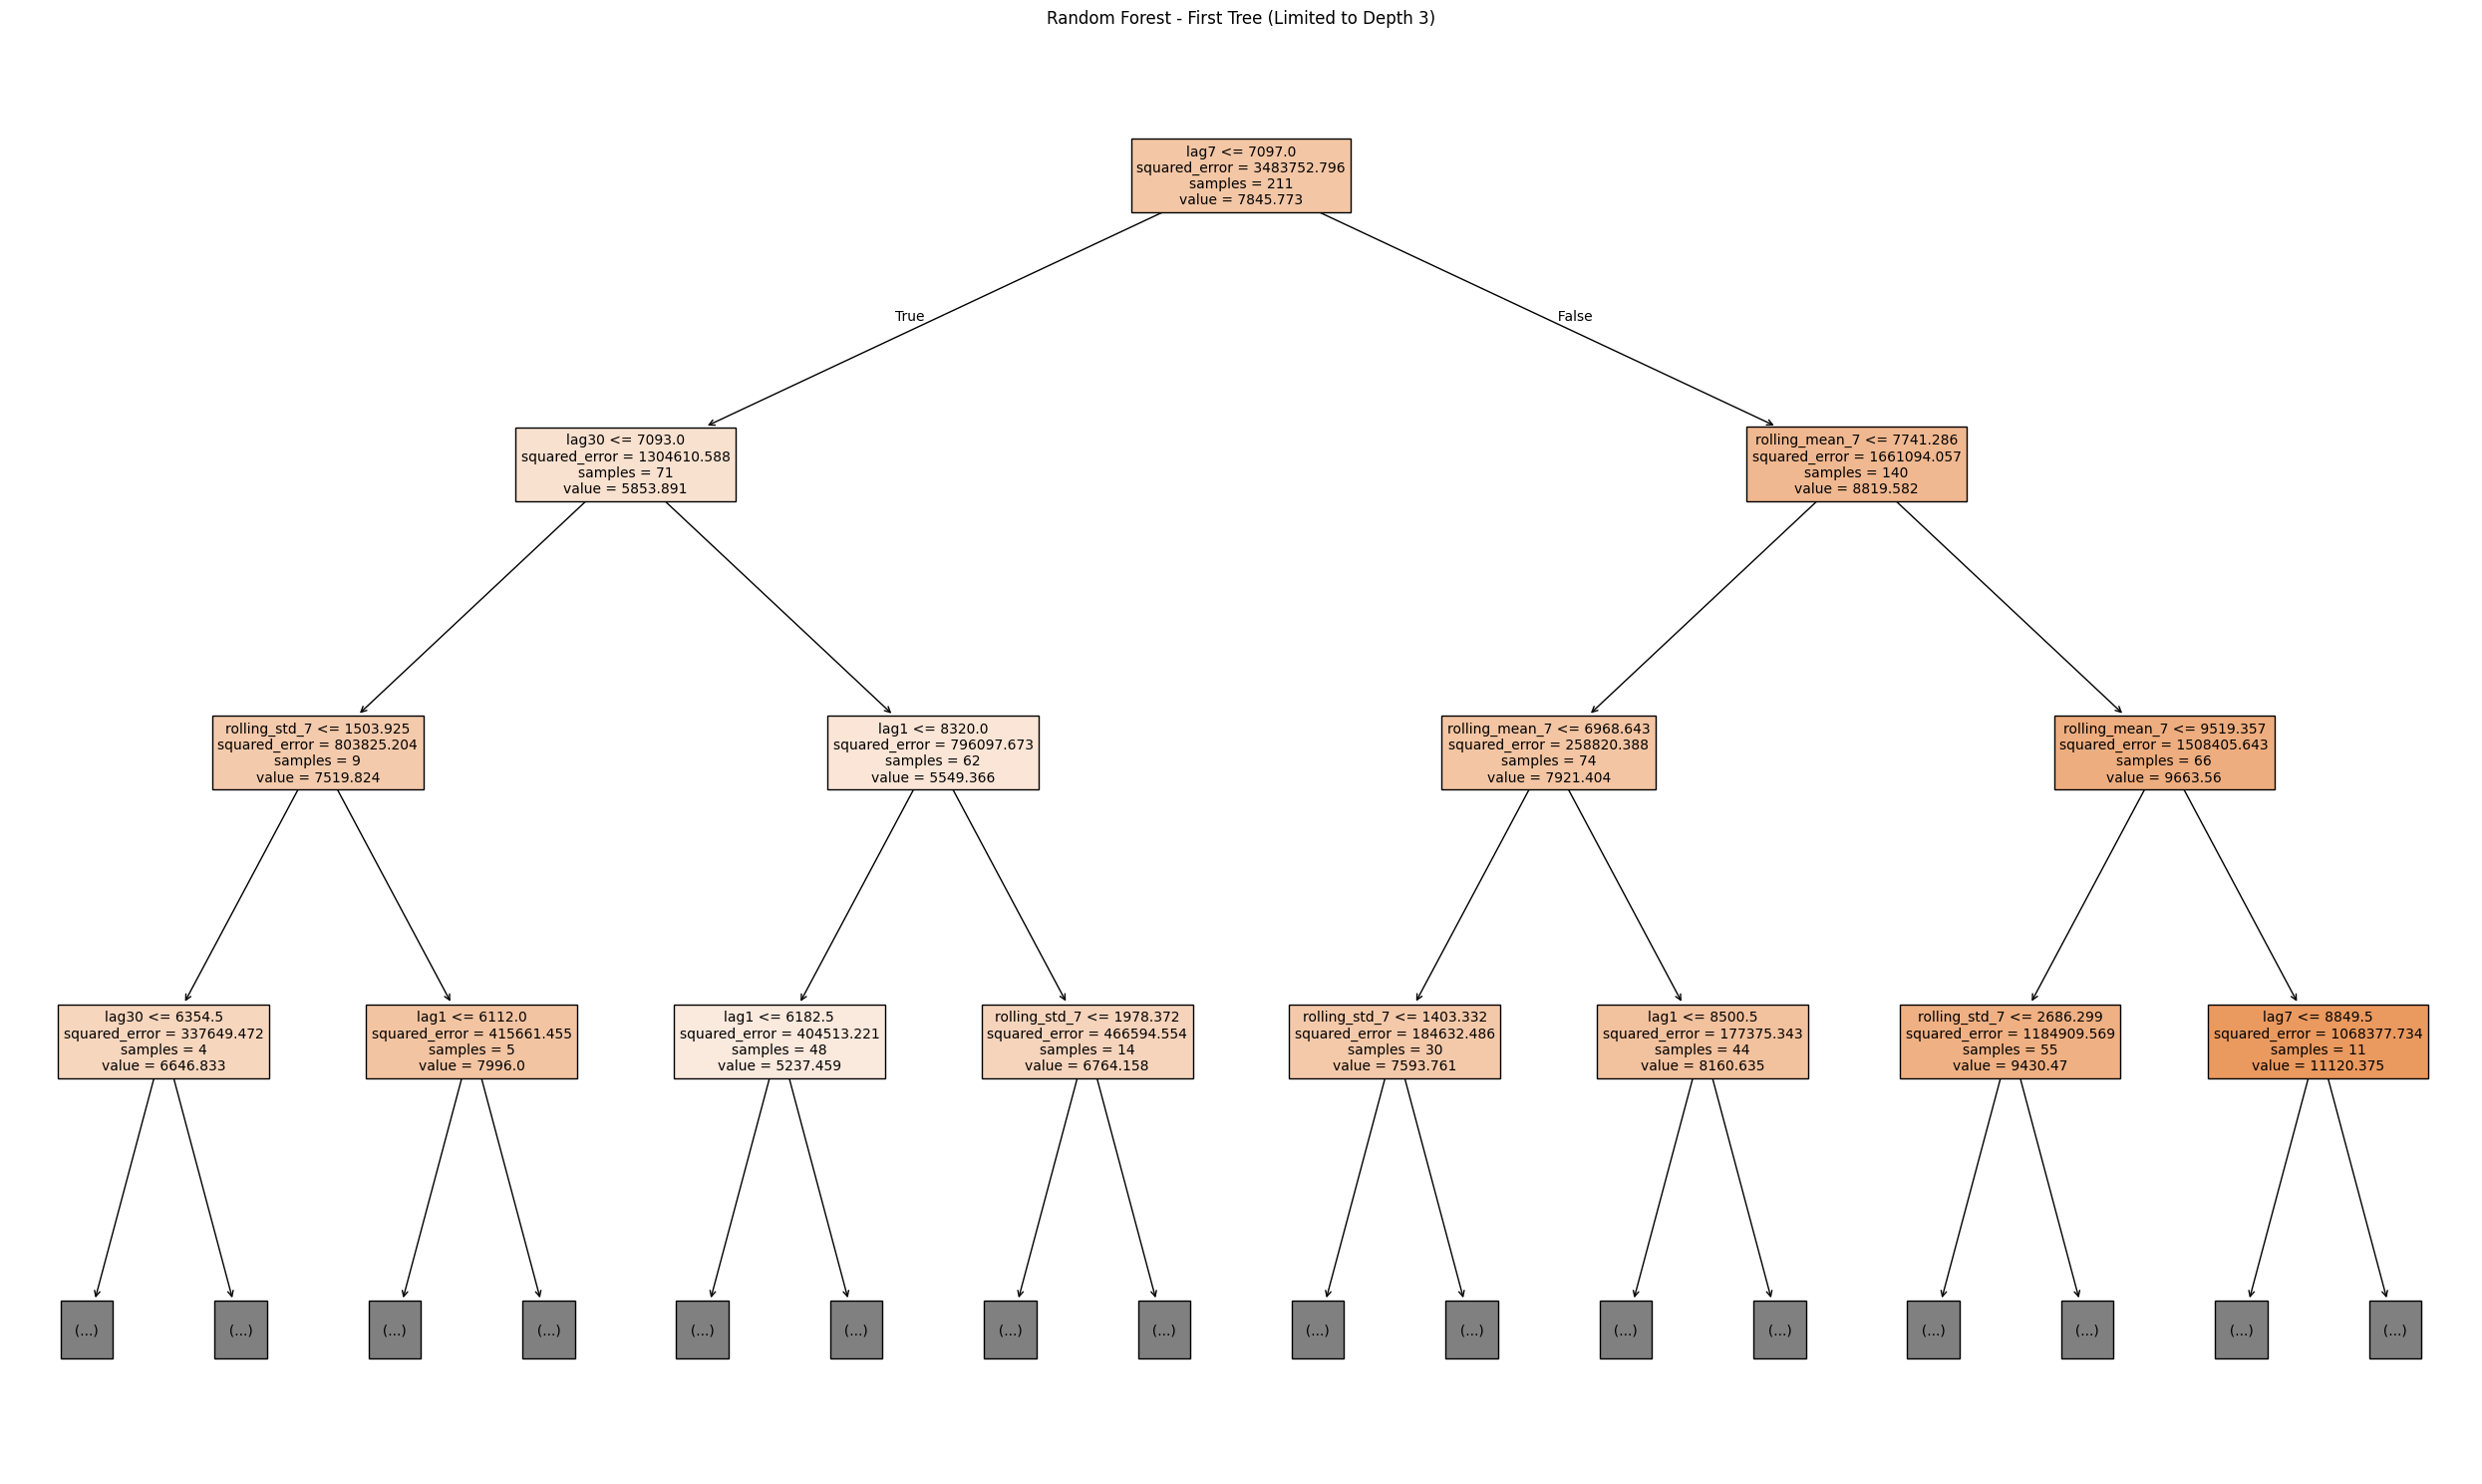


Random Forest has 100 trees
Each tree max depth: None


In [20]:
# --- Step 8: XGBoost Tree Visualization ---

print("\n=== XGBOOST TREE VISUALIZATION ===")

if champion_name == 'XGBoost':
    try:
        import xgboost as xgb
        from xgboost import plot_tree
        import matplotlib.pyplot as plt

        print(f"XGBoost model has {champion_fitted.n_estimators} trees")

        # Plot the first few trees
        trees_to_plot = min(3, champion_fitted.n_estimators)  # Plot first 3 trees

        for i in range(trees_to_plot):
            plt.figure(figsize=(20, 10))
            plot_tree(champion_fitted, num_trees=i, rankdir='TB', ax=plt.gca())
            plt.title(f'XGBoost Decision Tree #{i}')
            plt.tight_layout()
            plt.show()

        # Tree statistics
        print(f"\nTree Statistics:")
        print(f"Number of trees: {champion_fitted.n_estimators}")
        print(f"Max depth: {champion_fitted.max_depth}")
        print(f"Learning rate: {champion_fitted.learning_rate}")

        # Feature importance from trees
        feature_importance = champion_fitted.get_booster().get_score(importance_type='weight')
        print(f"\nTop 10 Features by Split Frequency:")
        sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
        for feature, count in sorted_features[:10]:
            print(f"  {feature}: {count} splits")

    except ImportError:
        print("xgboost plotting functions not available. Install with: pip install xgboost[plotting]")
    except Exception as e:
        print(f"Tree visualization failed: {e}")

        # Alternative: Show feature splits information
        try:
            booster = champion_fitted.get_booster()
            feature_importance = booster.get_score(importance_type='weight')
            gain_importance = booster.get_score(importance_type='gain')

            print("\nFeature Importance (Alternative View):")
            print("=" * 50)
            print("By Split Frequency (weight):")
            sorted_weight = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
            for feature, weight in sorted_weight[:10]:
                print(f"  {feature}: {weight} splits")

            print("\nBy Information Gain:")
            sorted_gain = sorted(gain_importance.items(), key=lambda x: x[1], reverse=True)
            for feature, gain in sorted_gain[:10]:
                print(f"  {feature}: {gain:.4f} gain")

        except Exception as e2:
            print(f"Alternative feature analysis also failed: {e2}")

else:
    print(f"Tree visualization only available for XGBoost models. Current champion: {champion_name}")

    # For RandomForest, you can visualize individual trees differently
    if champion_name == 'RandomForest':
        try:
            from sklearn.tree import plot_tree as sklearn_plot_tree

            print("Visualizing first tree from Random Forest:")
            plt.figure(figsize=(25, 15))
            sklearn_plot_tree(champion_fitted.estimators_[0],
                            feature_names=X.columns,
                            max_depth=3,  # Limit depth for readability
                            filled=True,
                            fontsize=10)
            plt.title('Random Forest - First Tree (Limited to Depth 3)')
            plt.tight_layout()
            plt.show()

            print(f"\nRandom Forest has {champion_fitted.n_estimators} trees")
            print(f"Each tree max depth: {champion_fitted.max_depth}")

        except Exception as e:
            print(f"Random Forest tree visualization failed: {e}")